In [1]:
import re

import Levenshtein
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
filename = "prediction_output.json"
data = pd.read_json(filename)
data.head()

,input,output,gold
0,"BB&T and SunTrust have completed their merger,...",[Cause] BB&T and SunTrust have completed their...,[Cause] BB&T and SunTrust have completed their...
1,Given Tulip's lack of profitability (managemen...,[Cause] Tulip's lack of profitability [Relatio...,[Cause] Given Tulip's lack of profitability (m...
2,TC Energy's profitability is not directly tied...,[Cause] pipeline transportation costs are not ...,[Cause] pipeline transportation costs are not ...
3,"That said, Wynn has recently renovated rooms a...",[Cause] Wynn has recently renovated rooms and ...,[Cause] Wynn has recently renovated rooms and ...
4,We are keeping our fair value estimate for Dan...,[Cause] recently generated cash flows and our ...,[Cause] recently generated cash flows and our ...


In [3]:
def parse_instance(answer: str) -> tuple[dict[str, list[str]], str | None]:
    """Parse string answer to separate into class and spans
    Simple case:
    [Cause] This is a cause [Effect] This is an effect

    Complex case:
    [Cause] This cause 1 | This cause 2 [Effect] This effect 1 | This effect 2
    """
    # TODO (italo): Document the relation
    matches = re.findall(r"\[Cause\](.*?)\[Relation\](.*?)\[Effect\](.*?)$", answer)
    if not matches:
        return {
            "Cause": [],
            "Effect": [],
        }, "cause"
    causes, relation, effects = matches[0]
    causes = sorted(c.strip() for c in causes.split("|") if c.strip())
    effects = sorted(e.strip() for e in effects.split("|") if e.strip())
    relation = relation.strip()

    return {
        "Cause": causes,
        "Effect": effects,
    }, relation

In [4]:
parse_instance(data.iloc[0].output)

({'Cause': ['BB&T and SunTrust have completed their merger, forming Truist'],
  'Effect': ['drive the next step up in profitability for the franchises']},
 'enable')

In [5]:
def parse(row: str, col: str) -> tuple[str | None, str | None]:
    d, _ = parse_instance(row[col])
    if not d["Cause"] or not d["Effect"]:
        return None, None
    return d["Cause"][0], d["Effect"][0]

In [6]:
df = data.copy()
df[["pred_cause", "pred_effect"]] = df.apply(
    parse, col="output", axis=1, result_type="expand"
)
df[["gold_cause", "gold_effect"]] = df.apply(
    parse, col="gold", axis=1, result_type="expand"
)
# df = df.drop(columns=["output", "gold"]).dropna()
df = df.dropna()
df.head()

,input,output,gold,pred_cause,pred_effect,gold_cause,gold_effect
0,"BB&T and SunTrust have completed their merger,...",[Cause] BB&T and SunTrust have completed their...,[Cause] BB&T and SunTrust have completed their...,"BB&T and SunTrust have completed their merger,...",drive the next step up in profitability for th...,"BB&T and SunTrust have completed their merger,...",which we believe will drive the next step up i...
1,Given Tulip's lack of profitability (managemen...,[Cause] Tulip's lack of profitability [Relatio...,[Cause] Given Tulip's lack of profitability (m...,Tulip's lack of profitability,we do not believe the business maintains a cos...,Given Tulip's lack of profitability (managemen...,we do not believe the business maintains a cos...
2,TC Energy's profitability is not directly tied...,[Cause] pipeline transportation costs are not ...,[Cause] pipeline transportation costs are not ...,pipeline transportation costs are not tied to ...,TC Energy's profitability is not directly tied...,pipeline transportation costs are not tied to ...,TC Energy's profitability is not directly tied...
3,"That said, Wynn has recently renovated rooms a...",[Cause] Wynn has recently renovated rooms and ...,[Cause] Wynn has recently renovated rooms and ...,Wynn has recently renovated rooms and the gami...,the facility maintain market share over the ne...,Wynn has recently renovated rooms and the gami...,help the facility maintain market share over t...
4,We are keeping our fair value estimate for Dan...,[Cause] recently generated cash flows and our ...,[Cause] recently generated cash flows and our ...,recently generated cash flows and our higher n...,We are keeping our fair value estimate for Dan...,recently generated cash flows and our higher n...,We are keeping our fair value estimate for Dan...


In [7]:
len(df.query("pred_effect != gold_effect"))

1291

In [8]:
def clean_str(s: str) -> str:
    s = s.lower().strip()
    return re.sub(r"\s", "", s)


def symm_substr(a: str, b: str) -> bool:
    a = clean_str(a)
    b = clean_str(b)
    return a in b or b in a


df["cause_substr"] = df.apply(
    lambda x: symm_substr(x["pred_cause"], x["gold_cause"]), axis=1
)
df.query("pred_cause != gold_cause")["cause_substr"].value_counts()

cause_substr
True     669
False    398
Name: count, dtype: int64

In [9]:
df["effect_substr"] = df.apply(
    lambda x: symm_substr(x["pred_effect"], x["gold_effect"]), axis=1
)
df.query("pred_cause != gold_cause")["effect_substr"].value_counts()

effect_substr
True     715
False    352
Name: count, dtype: int64

In [10]:
def excess_words(a: str, b: str) -> int:
    a = a.lower().strip()
    b = b.lower().strip()

    if a in b:
        x = b.replace(a, "")
    else:
        x = a.replace(b, "")

    return x


def excess_words_count(a: str, b: str) -> int:
    return len(excess_words(a, b).split())


df_cause = df.query("(pred_cause != gold_cause) and cause_substr").copy()
df_cause["cause_excess"] = df_cause.apply(
    lambda x: excess_words(x["pred_cause"], x["gold_cause"]), axis=1
)
df_cause["cause_excess_count"] = df_cause.apply(
    lambda x: excess_words_count(x["pred_cause"], x["gold_cause"]), axis=1
)
print(df_cause['cause_excess_count'].describe())
df_cause.head()

count    669.000000
mean       7.038864
std        6.093949
min        0.000000
25%        2.000000
50%        6.000000
75%       10.000000
max       39.000000
Name: cause_excess_count, dtype: float64


,input,output,gold,pred_cause,pred_effect,gold_cause,gold_effect,cause_substr,effect_substr,cause_excess,cause_excess_count
1,Given Tulip's lack of profitability (managemen...,[Cause] Tulip's lack of profitability [Relatio...,[Cause] Given Tulip's lack of profitability (m...,Tulip's lack of profitability,we do not believe the business maintains a cos...,Given Tulip's lack of profitability (managemen...,we do not believe the business maintains a cos...,True,True,given (management has stated the business was...,17
6,We expect a primary growth driver to be the 20...,[Cause] Beyond's products emit 90% less greenh...,[Cause] Beyond's products emit 90% less green...,Beyond's products emit 90% less greenhouse gas...,a primary growth driver to be the 20% of consu...,Beyond's products emit 90% less greenhouse gas...,the 20% of consumers willing to adjust their h...,True,True,than their meat equivalents,4
10,This is largely attributable to greater capita...,[Cause] greater capital efficiency and busines...,[Cause] This is largely attributable to greate...,greater capital efficiency and business mix ti...,These high-yield loans drive the bank's except...,This is largely attributable to greater capita...,drive the bank's exceptional net interest marg...,True,True,this is largely attributable to,5
13,"As evidence that Gap lacks a competitive edge,...",[Cause] Gap lacks a competitive edge [Relation...,[Cause] evidence that Gap lacks a competitive...,Gap lacks a competitive edge,its operating margins and returns on invested ...,evidence that Gap lacks a competitive edge,its operating margins and returns on invested ...,True,True,evidence that,2
14,"However, if people start opting to use debit c...",[Cause] people start opting to use debit cards...,[Cause] people start opting to use debit card...,people start opting to use debit cards rather ...,eat into Discover's ability to generate intere...,people start opting to use debit cards,Discover's ability to generate interest income,True,True,rather than credit cards,4


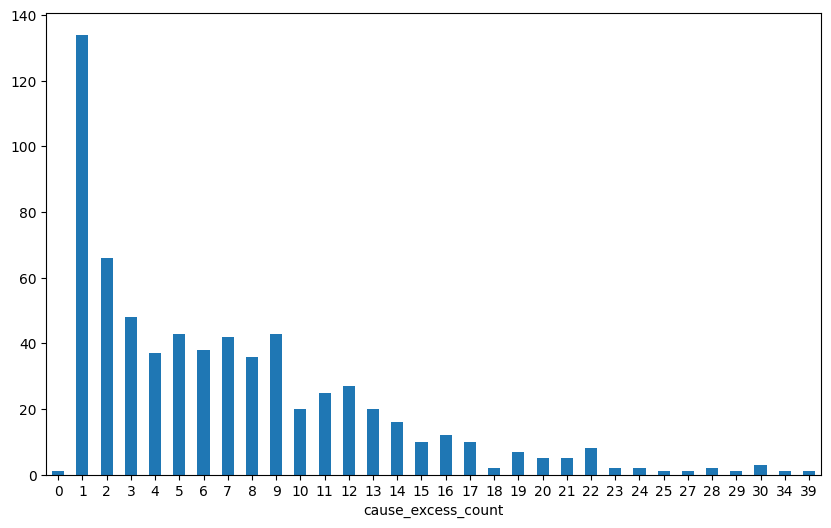

In [11]:
plt.figure(figsize=(10, 6))

excess_count = df_cause["cause_excess_count"].value_counts().sort_index()
ax = excess_count.plot(kind="bar")
ax.set_xticklabels(excess_count.index, rotation=0)

plt.show()

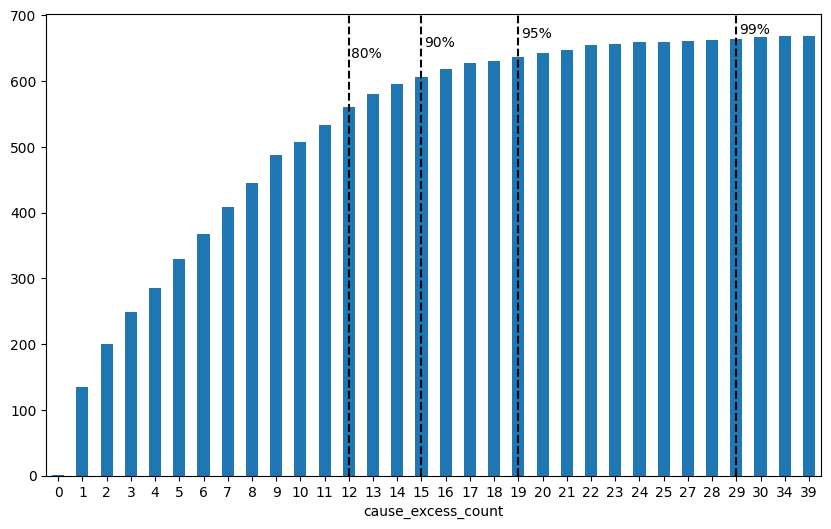

In [12]:
plt.figure(figsize=(10, 6))

excess_count = df_cause["cause_excess_count"].value_counts().sort_index().cumsum()
ax = excess_count.plot(kind="bar")
ax.set_xticklabels(excess_count.index, rotation=0)

percentiles = [0.8, 0.9, 0.95, 0.99]
heights = [100, 50, 30, 10]
for percentile, height in zip(percentiles, heights):
    target_percentile = percentile * excess_count.max()
    value_at_percentile = excess_count[excess_count >= target_percentile].index[0]
    ax.axvline(x=value_at_percentile, color="black", linestyle="--")
    ax.annotate(
        f"{int(percentile * 100)}%",
        (value_at_percentile + 0.1, target_percentile + height),
        color="black",
    )

plt.show()

In [13]:
df_effect = df.query("(pred_effect != gold_effect) and effect_substr").copy()
df_effect["effect_excess"] = df_effect.apply(
    lambda x: excess_words(x["pred_effect"], x["gold_effect"]), axis=1
)
df_effect["effect_excess_count"] = df_effect.apply(
    lambda x: excess_words_count(x["pred_effect"], x["gold_effect"]), axis=1
)
print(df_effect['effect_excess_count'].describe())
df_effect.head()

count    879.000000
mean       5.374289
std        5.326884
min        1.000000
25%        2.000000
50%        3.000000
75%        8.000000
max       38.000000
Name: effect_excess_count, dtype: float64


,input,output,gold,pred_cause,pred_effect,gold_cause,gold_effect,cause_substr,effect_substr,effect_excess,effect_excess_count
0,"BB&T and SunTrust have completed their merger,...",[Cause] BB&T and SunTrust have completed their...,[Cause] BB&T and SunTrust have completed their...,"BB&T and SunTrust have completed their merger,...",drive the next step up in profitability for th...,"BB&T and SunTrust have completed their merger,...",which we believe will drive the next step up i...,True,True,which we believe will,4
3,"That said, Wynn has recently renovated rooms a...",[Cause] Wynn has recently renovated rooms and ...,[Cause] Wynn has recently renovated rooms and ...,Wynn has recently renovated rooms and the gami...,the facility maintain market share over the ne...,Wynn has recently renovated rooms and the gami...,help the facility maintain market share over t...,True,True,help,1
5,We expect that management will continue to pur...,[Cause] management will continue to pursue acq...,[Cause] management will continue to pursue ac...,management will continue to pursue acquisition...,further lower the cyclicality of Fortive's por...,management will continue to pursue acquisition...,the cyclicality of Fortive's portfolio,True,True,further lower,2
6,We expect a primary growth driver to be the 20...,[Cause] Beyond's products emit 90% less greenh...,[Cause] Beyond's products emit 90% less green...,Beyond's products emit 90% less greenhouse gas...,a primary growth driver to be the 20% of consu...,Beyond's products emit 90% less greenhouse gas...,the 20% of consumers willing to adjust their h...,True,True,a primary growth driver to be,6
10,This is largely attributable to greater capita...,[Cause] greater capital efficiency and busines...,[Cause] This is largely attributable to greate...,greater capital efficiency and business mix ti...,These high-yield loans drive the bank's except...,This is largely attributable to greater capita...,drive the bank's exceptional net interest marg...,True,True,these high-yield loans,3


In [14]:
df_diff = df.query("pred_cause != gold_cause or pred_effect != gold_effect")
len(df_diff)

1597

In [15]:
df.query("pred_cause == gold_cause")['cause_substr'].value_counts()

cause_substr
True    1360
Name: count, dtype: int64

In [16]:
df_diff['cause_substr'].value_counts()

cause_substr
True     1199
False     398
Name: count, dtype: int64

In [17]:
df_diff['effect_substr'].value_counts()

effect_substr
True     1185
False     412
Name: count, dtype: int64

In [18]:
(df_diff['cause_substr'] & df_diff['effect_substr']).value_counts()

True     1006
False     591
Name: count, dtype: int64

In [19]:
df_substr = df_diff.query("cause_substr and effect_substr").copy()
len(df_substr)

1006

In [20]:
df_substr["cause_excess"] = df_substr.apply(
    lambda x: excess_words(x["pred_cause"], x["gold_cause"]), axis=1
)
df_substr["cause_excess_count"] = df_substr.apply(
    lambda x: excess_words_count(x["pred_cause"], x["gold_cause"]), axis=1
)
df_substr["cause_excess_count"].describe()

count    1006.00000
mean        3.39165
std         5.41177
min         0.00000
25%         0.00000
50%         1.00000
75%         5.00000
max        39.00000
Name: cause_excess_count, dtype: float64

In [21]:
df_substr["effect_excess"] = df_substr.apply(
    lambda x: excess_words(x["pred_effect"], x["gold_effect"]), axis=1
)
df_substr["effect_excess_count"] = df_substr.apply(
    lambda x: excess_words_count(x["pred_effect"], x["gold_effect"]), axis=1
)
df_substr["effect_excess_count"].describe()

count    1006.000000
mean        3.588469
std         4.835773
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        38.000000
Name: effect_excess_count, dtype: float64

In [22]:
df_substr.head()

,input,output,gold,pred_cause,pred_effect,gold_cause,gold_effect,cause_substr,effect_substr,cause_excess,cause_excess_count,effect_excess,effect_excess_count
0,"BB&T and SunTrust have completed their merger,...",[Cause] BB&T and SunTrust have completed their...,[Cause] BB&T and SunTrust have completed their...,"BB&T and SunTrust have completed their merger,...",drive the next step up in profitability for th...,"BB&T and SunTrust have completed their merger,...",which we believe will drive the next step up i...,True,True,,0,which we believe will,4
1,Given Tulip's lack of profitability (managemen...,[Cause] Tulip's lack of profitability [Relatio...,[Cause] Given Tulip's lack of profitability (m...,Tulip's lack of profitability,we do not believe the business maintains a cos...,Given Tulip's lack of profitability (managemen...,we do not believe the business maintains a cos...,True,True,given (management has stated the business was...,17,,0
3,"That said, Wynn has recently renovated rooms a...",[Cause] Wynn has recently renovated rooms and ...,[Cause] Wynn has recently renovated rooms and ...,Wynn has recently renovated rooms and the gami...,the facility maintain market share over the ne...,Wynn has recently renovated rooms and the gami...,help the facility maintain market share over t...,True,True,,0,help,1
5,We expect that management will continue to pur...,[Cause] management will continue to pursue acq...,[Cause] management will continue to pursue ac...,management will continue to pursue acquisition...,further lower the cyclicality of Fortive's por...,management will continue to pursue acquisition...,the cyclicality of Fortive's portfolio,True,True,,0,further lower,2
6,We expect a primary growth driver to be the 20...,[Cause] Beyond's products emit 90% less greenh...,[Cause] Beyond's products emit 90% less green...,Beyond's products emit 90% less greenhouse gas...,a primary growth driver to be the 20% of consu...,Beyond's products emit 90% less greenhouse gas...,the 20% of consumers willing to adjust their h...,True,True,than their meat equivalents,4,a primary growth driver to be,6


In [23]:
df_substr.to_json("substr.json", orient="records")

In [24]:
df_nosub = df.query("(pred_cause != gold_cause) and (not cause_substr or not effect_substr)").copy()
df_nosub.head()

,input,output,gold,pred_cause,pred_effect,gold_cause,gold_effect,cause_substr,effect_substr
8,"With governments on national, state, and local...",[Cause] COVID-19 [Relation] cause [Effect] bud...,"[Cause] governments on national, state, and lo...",COVID-19,budget problems and emergency expenses,"governments on national, state, and local leve...",the emergence of cannabis as a legal product h...,False,False
9,"With governments on national, state, and local...",[Cause] the emergence of cannabis as a legal p...,[Cause] budget problems and emergency expenses...,the emergence of cannabis as a legal product,viewed as a funding panacea,budget problems and emergency expenses from CO...,"governments on national, state, and local leve...",False,False
15,As licenses for these facilities are given by ...,[Cause] licenses for these facilities are give...,[Cause] licenses for these facilities are giv...,licenses for these facilities are given by sta...,Teleflex could face supply disruptions,ethylene oxide becomes a priority for state of...,Teleflex could face supply disruptions,False,True
17,"Additionally, properties located in desirable ...",[Cause] properties located in desirable submar...,[Cause] low crime statistics see higher demand...,properties located in desirable submarkets wit...,higher demand,low crime statistics see higher demand,higher rents and higher growth,False,False
40,"Over the past decade, the HDD market has exper...",[Cause] an inability to meet the rising invest...,[Cause] others have exited [Relation] cause [...,an inability to meet the rising investments to...,the number of players falling from 10 to three,others have exited,the number of players falling from 10 to three,False,True


In [25]:
nosub_agg = df_nosub.groupby(["cause_substr", "effect_substr"])['input'].count().reset_index()
nosub_agg

,cause_substr,effect_substr,input
0,False,False,219
1,False,True,179
2,True,False,133


In [26]:
print(nosub_agg.to_markdown(tablefmt="simple", index=False))

cause_substr    effect_substr      input
--------------  ---------------  -------
False           False                219
False           True                 179
True            False                133


In [27]:
df_nosub.shape

(531, 9)

In [28]:
df_nosub.to_json("prediction_nosubstr.json", orient="records")